BACKTEST COMPLETED | Trades: 243


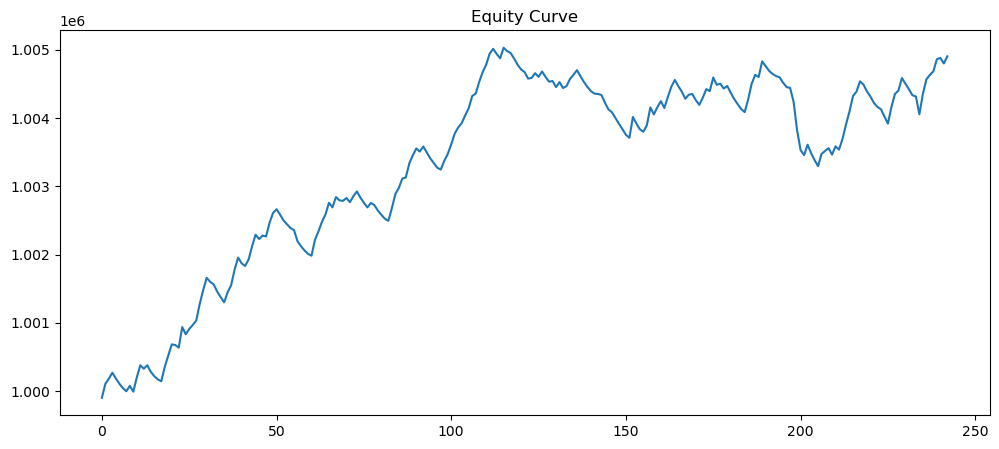

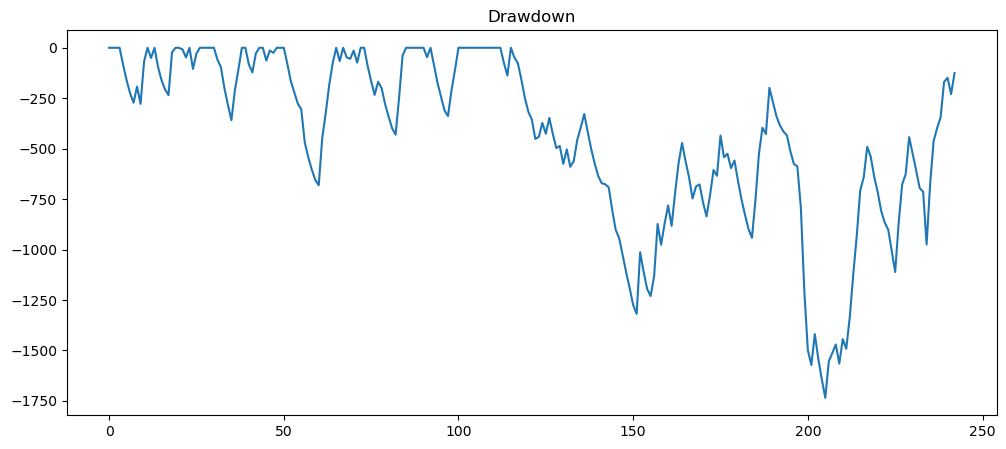

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
FUTURES_FILE = "BANKNIFTY_2017_FUTURES.csv"
OPTIONS_FILE = "BANKNIFTY_2017_OPTIONS.csv"

START_CAPITAL = 10_00_000
ENTRY_TIME = "10:30"
EXIT_TIME = "15:20"

STOP_LOSS_PCT = 0.30
TARGET_PCT = 0.80

# =========================
# LOAD DATA
# =========================
fut = pd.read_csv(FUTURES_FILE)
opt = pd.read_csv(OPTIONS_FILE)

fut["Datetime"] = pd.to_datetime(fut["Date"] + " " + fut["Time"])
opt["Datetime"] = pd.to_datetime(opt["Date"] + " " + opt["Time"])

fut["TradeDate"] = fut["Datetime"].dt.date
opt["TradeDate"] = opt["Datetime"].dt.date
opt["Expiry"] = pd.to_datetime(opt["Expiry"]).dt.date

fut.sort_values("Datetime", inplace=True)
opt.sort_values("Datetime", inplace=True)

# =========================
# HELPERS
# =========================
def round_100(x):
    return int(round(x / 100) * 100)

def next_expiry(day, expiries):
    for e in expiries:
        if e >= day:
            return e
    return None

def first_price(df, strike, typ):
    r = df[(df["Strike"] == strike) & (df["Type"] == typ)]
    if r.empty:
        return None
    return r.iloc[0]["Close"]

# =========================
# PREP
# =========================
trading_days = sorted(fut["TradeDate"].unique())
weekly_expiries = sorted(opt["Expiry"].unique())

capital = START_CAPITAL
equity_curve = []
trades = []

# =========================
# BACKTEST
# =========================
for day in trading_days:

    expiry = next_expiry(day, weekly_expiries)
    if expiry is None:
        continue

    entry_ts = pd.to_datetime(f"{day} {ENTRY_TIME}")

    fut_row = fut[fut["Datetime"] >= entry_ts].head(1)
    if fut_row.empty:
        continue

    atm = round_100(fut_row.iloc[0]["Close"])

    # ----- ENTRY OPTIONS (first quote after 10:30) -----
    opt_entry = opt[
        (opt["TradeDate"] == day) &
        (opt["Expiry"] == expiry) &
        (opt["Contract_Weekly"] == "I") &
        (opt["Datetime"] >= entry_ts)
    ].sort_values("Datetime")

    atm_ce = first_price(opt_entry, atm, "CE")
    atm_pe = first_price(opt_entry, atm, "PE")

    if atm_ce is None or atm_pe is None:
        continue

    entry_premium = atm_ce + atm_pe
    stop_loss = entry_premium * (1 + STOP_LOSS_PCT)
    target = entry_premium * (1 - TARGET_PCT)

    exit_price = None
    exit_reason = "EXPIRY"

    # ----- MONITOR -----
    monitor = opt[
        (opt["Expiry"] == expiry) &
        (opt["Contract_Weekly"] == "I") &
        (opt["Datetime"] > opt_entry.iloc[0]["Datetime"])
    ].sort_values("Datetime")

    for ts, grp in monitor.groupby("Datetime"):
        ce = first_price(grp, atm, "CE")
        pe = first_price(grp, atm, "PE")

        if ce is None or pe is None:
            continue

        combined = ce + pe

        if combined >= stop_loss:
            exit_price = combined
            exit_reason = "STOP_LOSS"
            break

        if combined <= target:
            exit_price = combined
            exit_reason = "TARGET"
            break

    # ----- EXPIRY EXIT (independent CE & PE pricing) -----
    if exit_price is None:
        exit_ts = pd.to_datetime(f"{expiry} {EXIT_TIME}")

        ce_exit = opt[
            (opt["Expiry"] == expiry) &
            (opt["Strike"] == atm) &
            (opt["Type"] == "CE") &
            (opt["Datetime"] >= exit_ts)
        ].sort_values("Datetime").head(1)

        pe_exit = opt[
            (opt["Expiry"] == expiry) &
            (opt["Strike"] == atm) &
            (opt["Type"] == "PE") &
            (opt["Datetime"] >= exit_ts)
        ].sort_values("Datetime").head(1)

        if ce_exit.empty or pe_exit.empty:
            continue

        exit_price = ce_exit.iloc[0]["Close"] + pe_exit.iloc[0]["Close"]

    pnl = entry_premium - exit_price
    capital += pnl
    equity_curve.append(capital)

    trades.append({
        "TradeDate": day,
        "Expiry": expiry,
        "ATM_Strike": atm,
        "EntryPremium": entry_premium,
        "ExitPremium": exit_price,
        "PnL": pnl,
        "ExitReason": exit_reason,
        "Capital": capital
    })

# =========================
# REPORTS
# =========================
trade_df = pd.DataFrame(trades)
trade_df.to_csv("TradeReport.csv", index=False)

if trade_df.empty:
    stats = {
        "Total Trades": 0,
        "Net PnL": 0,
        "ROI %": 0,
        "Win Rate %": 0,
        "Max Drawdown": 0
    }
else:
    equity = pd.Series(equity_curve)
    drawdown = equity - equity.cummax()

    stats = {
        "Total Trades": len(trade_df),
        "Net PnL": trade_df["PnL"].sum(),
        "ROI %": (capital - START_CAPITAL) / START_CAPITAL * 100,
        "Win Rate %": (trade_df["PnL"] > 0).mean() * 100,
        "Max Drawdown": drawdown.min()
    }

pd.DataFrame([stats]).to_csv("PerformanceStats.csv", index=False)

if equity_curve:
    equity = pd.Series(equity_curve)
    drawdown = equity - equity.cummax()

    plt.figure(figsize=(12,5))
    plt.plot(equity)
    plt.title("Equity Curve")
    plt.savefig("EquityCurve.png")

    plt.figure(figsize=(12,5))
    plt.plot(drawdown)
    plt.title("Drawdown")
    plt.savefig("Drawdown.png")

print("BACKTEST COMPLETED | Trades:", len(trade_df))
